# Dataset Description

This dataset contains a set of measurements made by pressure sensors installed on several mattresses with the purpose of collectiing in-bed  posture data. The data collection was performed by *Pouyan et. al (2017)* and was documented on the article:  __[A Pressure Map Data set for In-bed Posture Classification](https://ieeexplore.ieee.org/document/7897206/)__. The dataset is publicly available and hosted by the [Physionet](https://physionet.org) databank [here](https://physionet.org/content/pmd/1.0.0/). 

The data was collected using Force Sensitive Application (FSA) pressure mapping mattresses with a sample frequency of 1Hz. This pressure mat is light, thin, and flexible enough so it can covers the entire mattress. The data collection was divided into two phases (or experiments), as follows [(Pouyan et. al, 2017)](https://ieeexplore.ieee.org/document/7897206/):

*   **Experiment I:**  the sensors were uniformly distributed across a 32′′ × 64′′ mat with each sensor being almost one inch apart. 13 subjects participated in the experiment and performed eight standard bed postures (and some slight variations, summnig up to 17 unique postures), which were summarized (labeled) as five common bed postures: _left_, _right_, _left fetus_, _right fetus_, and _supine_. Each subject performed each pose for at most two minutes.

*   **Experiment II:**  two pressure mats were used, regular mattress and air alternating mattress with sensors uniformly distributed across 27′′ × 64′′ mat with each sensor being almost one inch apart. Eight subjects participated in this experiment and performed 29 postures that represent variations of the three common bed postures: _left_, _right_, and _supine_ (_left fetus_ and _right fetus_ were labeled  as _left_ and _right_, respectively). However, just one measurement per position is given. This measurement corresponds to the mean pressure value after 20 seconds of measurements.

  **Note:** subject three perform three additional postures but they were not documented. Hence, we performed a manual inspection before labeling them.

## Downloading the dataset

As mentioned above, this dataset is publicly available, so we will download it here and rename the folder as "dataset":

In [1]:
!wget https://physionet.org/static/published-projects/pmd/a-pressure-map-dataset-for-in-bed-posture-classification-1.0.0.zip
!unzip -q a-pressure-map-dataset-for-in-bed-posture-classification-1.0.0.zip
!mv a-pressure-map-dataset-for-in-bed-posture-classification-1.0.0 dataset 

--2019-08-18 17:57:22--  https://physionet.org/static/published-projects/pmd/a-pressure-map-dataset-for-in-bed-posture-classification-1.0.0.zip
Resolving physionet.org (physionet.org)... 128.30.30.88
Connecting to physionet.org (physionet.org)|128.30.30.88|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 107315828 (102M) [application/zip]
Saving to: ‘a-pressure-map-dataset-for-in-bed-posture-classification-1.0.0.zip.2’

a-pressure-map-data 100%[===================>] 102.34M  35.6MB/s    in 2.9s    

2019-08-18 17:57:25 (35.6 MB/s) - ‘a-pressure-map-dataset-for-in-bed-posture-classification-1.0.0.zip.2’ saved [107315828/107315828]

mv: cannot move 'a-pressure-map-dataset-for-in-bed-posture-classification-1.0.0' to 'dataset/a-pressure-map-dataset-for-in-bed-posture-classification-1.0.0': Directory not empty


##Libraries and utilities

In [2]:
# Data Load
import os
import numpy as np

# PyTorch (modeling)
import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision import transforms
import torchvision.transforms.functional as TF

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Setting a seed to ensure reproductibility
torch.manual_seed(123)

# Exploratory Data Analysis

We now have a folder called __dataset__. The structure of this folder is the following

```
dataset/
|
| --- experiment-i/
|         |--- S1/
|              |---- 1.txt
|              |---- 2.txt
|              ...
|          |--- S2/
|          ...
| --- experiment-ii/
|         |--- S1/
|              |---- Air_Mat/
|                       |--- Matrix_Air_B1.txt
|                       |--- Matrix_Air_B2.txt
|                       ...
|              |---- Sponge_Mat/
|                       |--- Matrix_Sponge_B1.txt
|                       |--- Matrix_Sponge_B2.txt
|                       ...
...

```

In this section we will do an *Exploratory Data Analysis (EDA)* over the dataset. That is, we will explore the data by loadiing it and making some test plots so we can understand the structure of every measurement and we can perform any pre-processing ot theh data before going to the modeling phase. We will separate this exploration on two parts, one for each experiment.

## Experiment I

In this experiment 13 subjects participated and performed 17 unique postures. Each posture is contained on a separate `.txt` file. 


In [3]:
exp_i_path = './dataset/experiment-i/'
# Read subjects
subjects_i = [file for file in os.listdir(exp_i_path) if os.path.isdir(os.path.join(exp_i_path, file))]
print(f"The subjects on the Experiment I are: {subjects_i}")

The subjects on the Experiment I are: ['S11', 'S6', 'S7', 'S8', 'S9', 'S13', 'S5', 'S4', 'S3', 'S12', 'S2', 'S1', 'S10']


Here we inspect one file:

In [4]:
test_read = np.loadtxt("dataset/experiment-i/S2/9.txt")
test_read.shape

(80, 2048)

Since the mat is composed by an arrangement of 32 x 64 (= 2048) sensors, it is correct to assume that the columns of the former `ndarray` correspond to the measurements of each sensor and the rows are the different measurements done. Here we inspect the sixth measurement of the data we just imported:

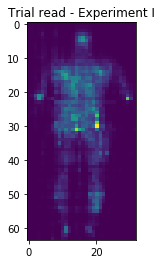

In [5]:
plt.title("Trial read - Experiment I")
fig = plt.imshow(test_read[6,:].reshape(64,32))


We also noticed that the first two measurements of all files do not display the data correctly, so we ignored them for the rest of the project.

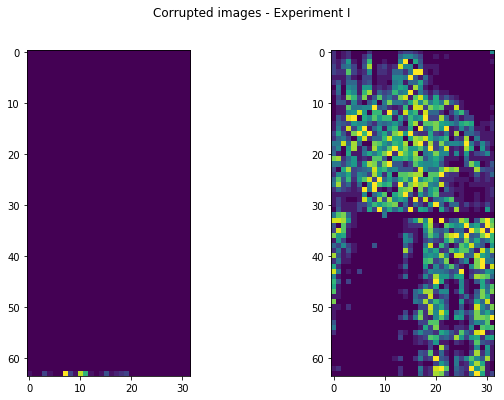

In [6]:
fig, axes = plt.subplots(figsize=(10,6), ncols=2)
fig.suptitle("Corrupted images - Experiment I")
for ii in range(2):
    ax = axes[ii]
    ax.imshow(test_read[ii,:].reshape(64,32))

First we set a 'Position vector': We load the data with respect to the file name, which is a number corresponding to a specific in-bed position. We take advantage of this and use the number to get the position with help of the following vectors.

In [0]:
positions_i = ["justAPlaceholder", "supine", "right",
                     "left", "right", "right",
                     "left", "left", "supine",
                     "supine", "supine", "supine",
                     "supine", "right", "left",
                     "supine", "supine", "supine"]

We also want the classes to be encoded as numbers so we can work easier when modeling. This function achieves so. Since left_fetus and right_fetus are not considered as classes in the evaluation of the original paper and since they are not considered in the "Experiment I", we encode them also as left and right positions. 

Note: one could set directly the `positions_i` values as numbers, but we wanted to make it this explicit with another function for clarity.

In [0]:
def token_position(x):
    return {
        'supine': 0,
        'left': 1,
        'right': 2,
        'left_fetus': 1,
        'right_fetus': 2
    }[x]

Now we will load the data into a dictionary, where the keys will be the subjects:

In [9]:
exp_i_data = {}

for _, dirs, _ in os.walk(exp_i_path):
  for directory in dirs:
    # each directory is a subject
    subject = directory
    data = None
    labels = None
    for _, _, files in os.walk(os.path.join(exp_i_path, directory)):
      for file in files:
        file_path = os.path.join(exp_i_path, directory, file)
        with open(file_path, 'r') as f:
          # Start from second recording, as the first two are corrupted
          for line in f.read().splitlines()[2:]:

            raw_data = np.fromstring(line, dtype=float, sep='\t')
            # Change the range from [0-1000] to [0-255].
            file_data = np.round(raw_data*255/1000).astype(np.uint8)
            Normalize = transforms.Compose([
                        transforms.ToPILImage(),
                        transforms.ToTensor()])
            file_data = Normalize(file_data.reshape(64,32))
            file_data = file_data.view(1, 64, 32)
            # Turn the file index into position list,
            # and turn position list into reduced indices.
            file_label = token_position(positions_i[int(file[:-4])])
            file_label = np.array([file_label])

            if data is None:
              data = file_data
            else:
              data = np.concatenate((data, file_data), axis=0)
            if labels is None:
              labels = file_label
            else:
              labels = np.concatenate((labels, file_label), axis=0)

      exp_i_data[subject] = (torch.from_numpy(data), torch.from_numpy(labels))
      
      
exp_i_data.keys()

dict_keys(['S11', 'S6', 'S7', 'S8', 'S9', 'S13', 'S5', 'S4', 'S3', 'S12', 'S2', 'S1', 'S10'])

**Data loading is a mandatory step in our further notebooks. To avoid code repetition, we created a `helper.py` file where we will store several of these processes as functions. The process of loading of the data for this experiment was defined as the function `load_exp_i()`.**

Now we took a look of 24 images per subject:

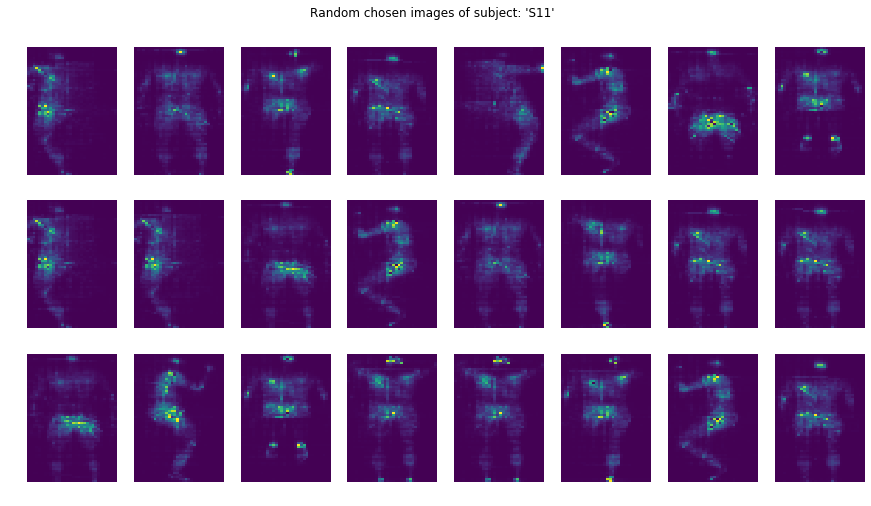

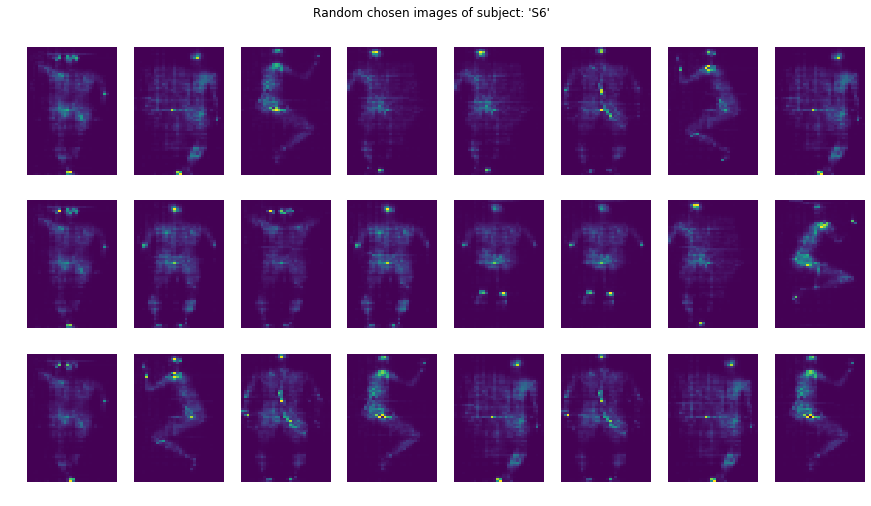

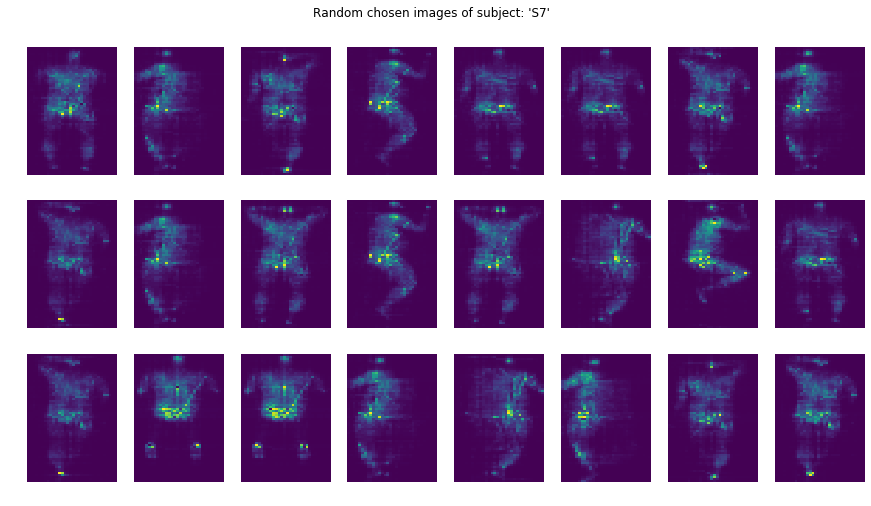

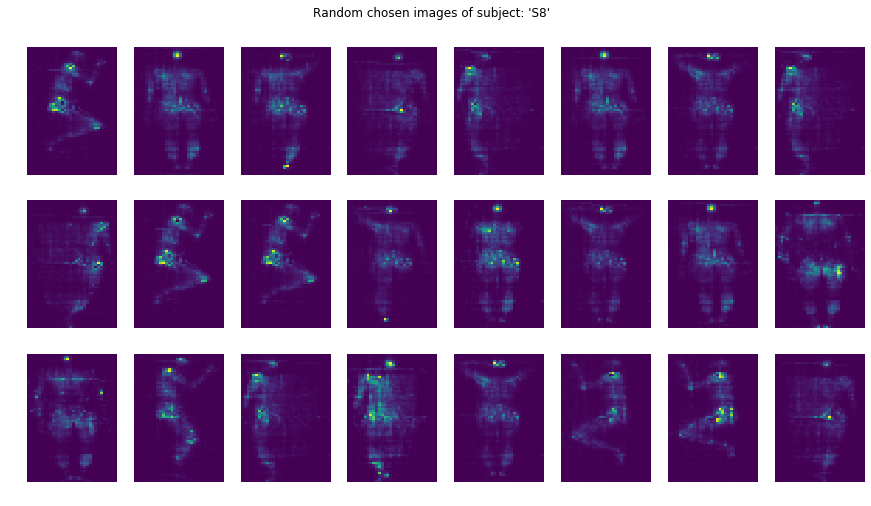

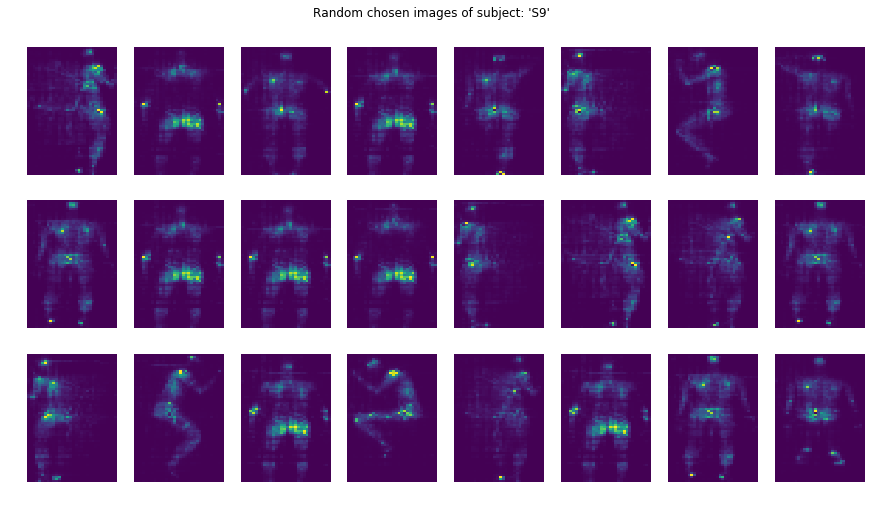

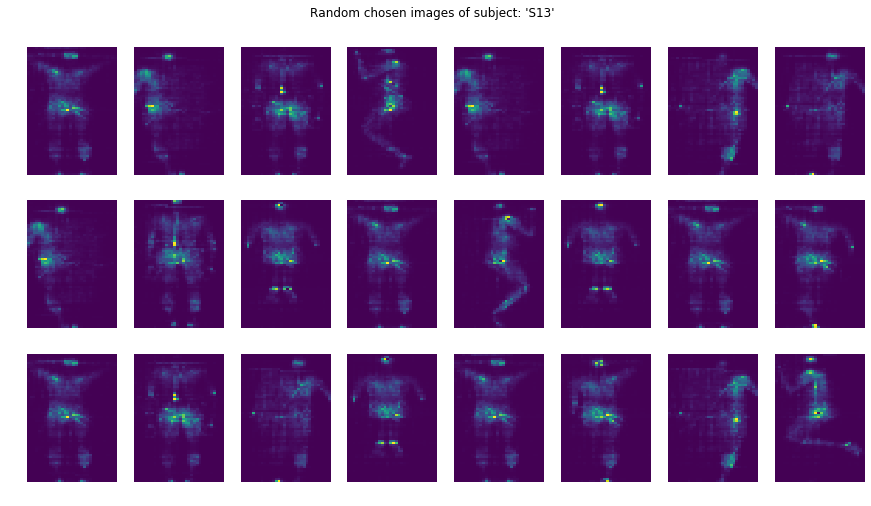

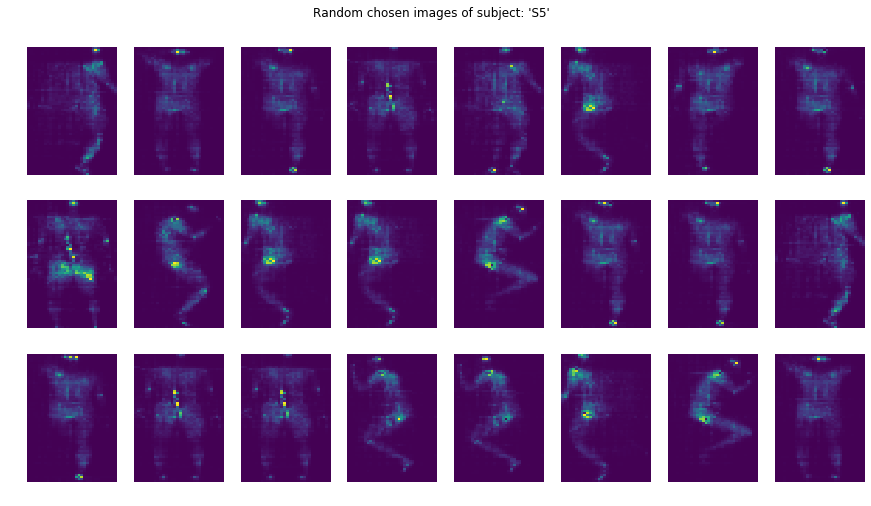

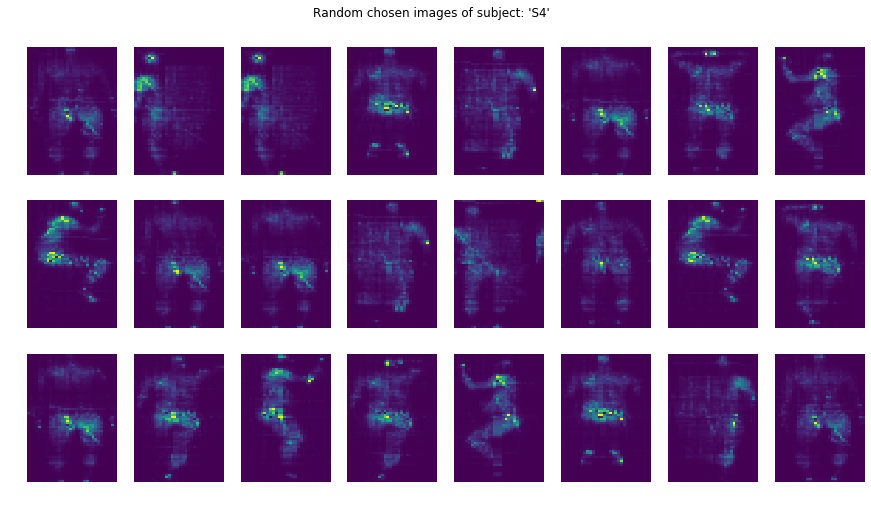

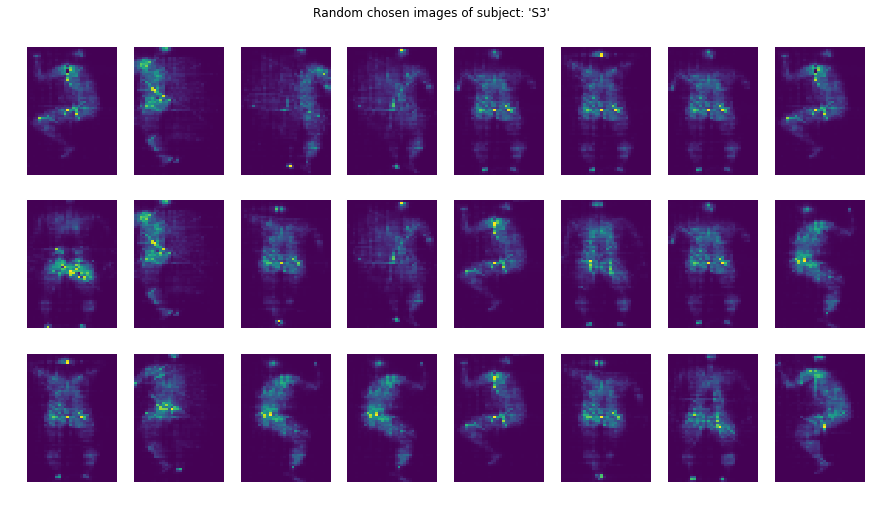

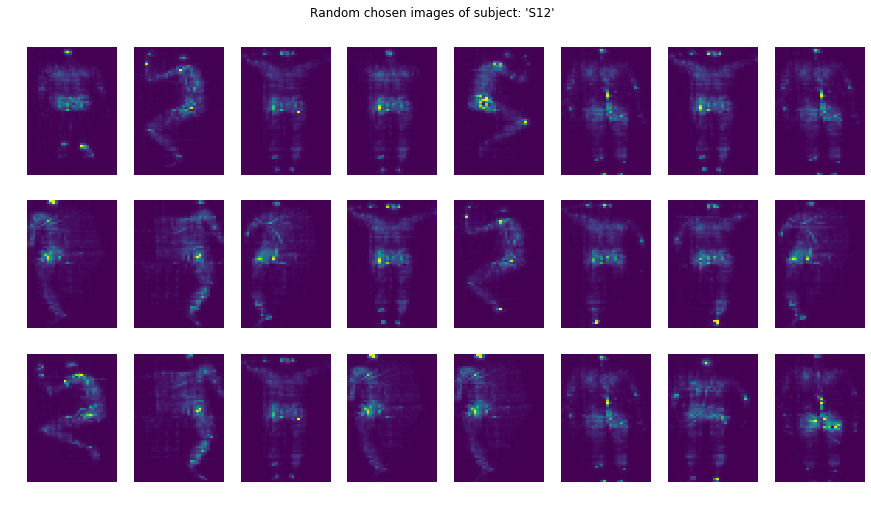

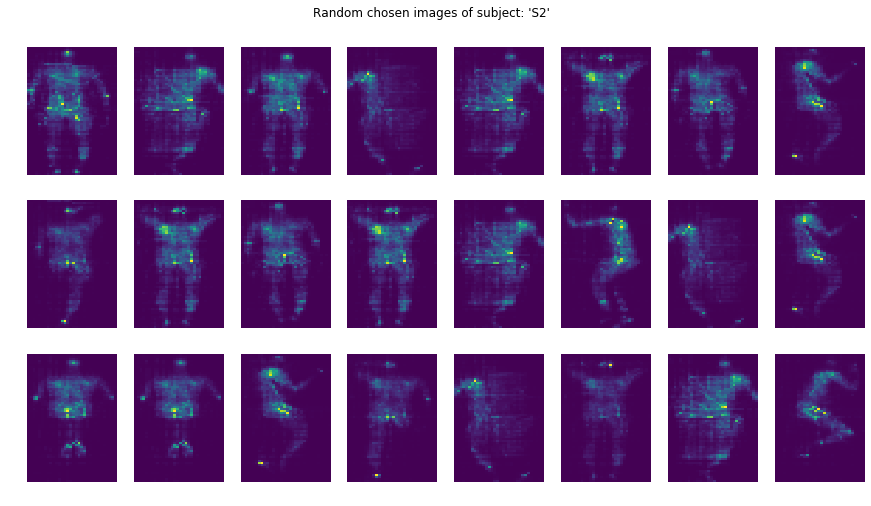

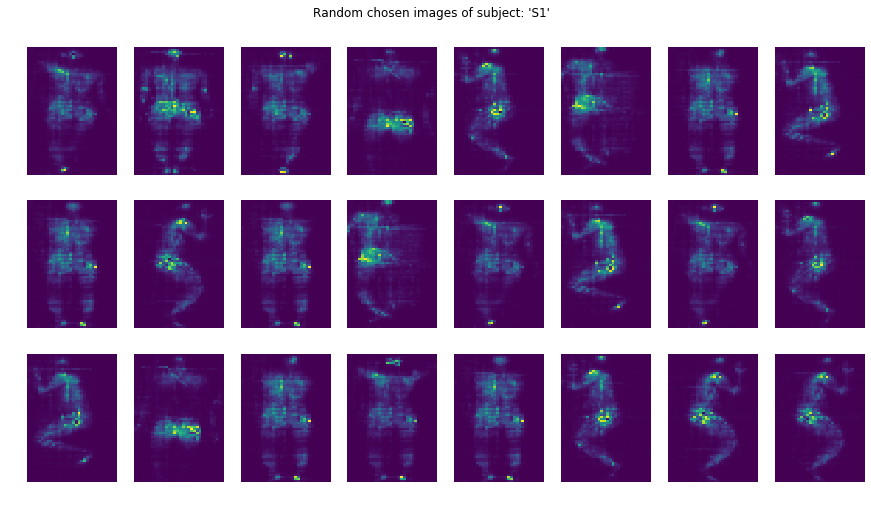

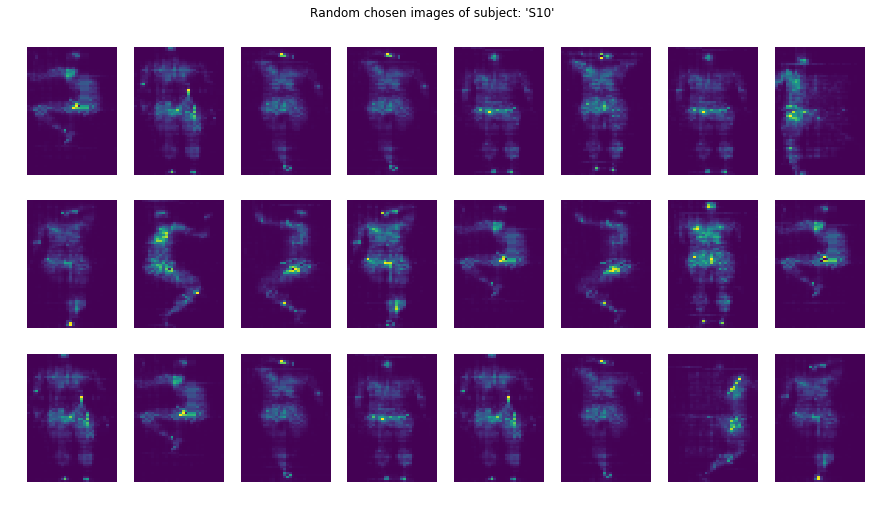

In [10]:
for subject in subjects_i:

  # read the subject
  size = exp_i_data[subject][0].shape[0]
  # sample
  sample = np.random.choice(range(0, size), 24, replace = False)
  # data
  data = exp_i_data[subject][0].numpy()
  # plots
  f, arr = plt.subplots(3, 8, figsize = (15, 8))
  f.suptitle(f'Random chosen images of subject: \'{subject}\'', y = 0.95)
  fig = 0
  for r in range(3):
      for c in range(8):
          arr[r, c].imshow(data[sample[fig]].reshape(64, 32), aspect = 'auto')
          arr[r, c].axis('off')
          fig += 1

After observing the data, it seems that some samples have a degree of noise. This might be explained a transitional pressure recording when the person was moving from one position to the other. Even though there were 17 unique positions recordered, one can visually inspect and separate them into the five common postures mention previously:  _left_, _right_, _left fetus_, _right fetus_, and _supine_. 

We decided to label the 'fetus' positions as the corresponding left/right positions, because the former positions were not included in 'Experiment II", nor considered in any of the analyses of the authors of the data collection.

We finally make a count of the number of available positions in the dataset:

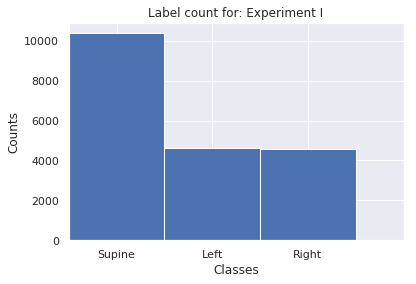

In [11]:
mats = ['Experiment I', 'Experiment II - Air Mat', 'Experiment II - Sponge Mat']

def plot_hist(data_dict, mat):
  keys = list(data_dict.keys())
  data = data_dict[keys[0]][1].numpy()
  for x in keys[1:]:
      data = np.append(data, data_dict[x][1], axis = 0)
  fig, ax = plt.subplots()
  numbers=[x for x in range(0,3)]
  labels=map(lambda x: str(x), numbers)
  plt.xticks(numbers, labels)
  plt.xlim(-0.5,3)
  plt.hist(data, bins=np.arange(4)-0.5)
  labels = ['Supine', 'Left', 'Right']
  ax.set_xticklabels(labels)
  plt.title('Label count for: {}'.format(mat))
  plt.xlabel('Classes')
  plt.ylabel('Counts')
  plt.show()

# Activate seaborn for this visualization
sns.set()
plot_hist(exp_i_data, mats[0])

In [0]:
# Go back to matplotlib
%%capture
sns.reset_orig()

As we can see, most of the dataset consists of  __supine__ postures.


## Experiment II

In this experiment 8 subjects participated and performed 29 unique postures. Each posture is contained on a separate `.txt` file. Additionally, only one measurement is available, which corresponds to the mean pressure value after 20 seconds of measurement.

In [13]:
exp_ii_path = './dataset/experiment-ii/'
# Read subjects
subjects_ii = [file for file in os.listdir(exp_ii_path) if os.path.isdir(os.path.join(exp_ii_path, file))]
print(f"The subjects on the Experiment I are: {subjects_ii}")

The subjects on the Experiment I are: ['S6', 'S7', 'S8', 'S5', 'S4', 'S3', 'S2', 'S1']


In [14]:
test_read = np.loadtxt("dataset/experiment-ii/S2/Air_Mat/Matrix_Air_B1.txt")
test_read.shape

(64, 27)

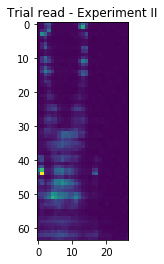

In [15]:
plt.title("Trial read - Experiment II")
fig = plt.imshow(test_read)

Both air and sponge mattresses used in the data collection have a different size (64 x 27), opposed to the pressure mattress (64 x 32) used in the first experiment. Additionally, the image is rotated by 180 degrees with respect to the images collected in the "Experiment I".

We created the function `resize_and_rotate()`  to set the format of the images equal to the ones taken in the "Experiment I":

In [0]:
def resize_and_rotate(image):
  To_PIL_and_Resize = transforms.Compose([
                      transforms.ToPILImage(),
                      transforms.Resize((64, 32))
                      ])

  rotated = TF.rotate(To_PIL_and_Resize(image), angle=180)

  return transforms.ToTensor()(rotated)

As a note, the range of the data values after loading is [0 - 1]. This is achieved because we initially set the range to [0 - 255], which is the range accepted for PIL images, and when we use `transforms.ToTensor()`, these values are mapped to a range from [0 - 1]. Following the same logic for loading the data for the previous experiment, and the `tree`showing how the data is arranged, we proceed to load the data:

In [0]:
# Positions G1, G2, and G3 appear only on Subject 3's air mat measurements. We
# inspected them manually to know the position of it and set the corresponding
# label.

positions_ii = {
    "B":"supine", "1":"supine", "C":"right",
    "D":"left", "E1":"right", "E2":"right",
    "E3":"left", "E4":"left", "E5":"right",
    "E6":"left", "F":"supine", "G1":"supine",
    "G2":"right", "G3":"left"
}

exp_ii_data_air = {}
exp_ii_data_spo = {}

# each directory is a subject
for _, subject_dirs, _ in os.walk(exp_ii_path):
  for subject in subject_dirs:
    data = None
    labels = None

    # each directory is a matress
    for _, mat_dirs, _ in os.walk(os.path.join(exp_ii_path, subject)):
      for mat in mat_dirs:
        for _, _, files in os.walk(os.path.join(exp_ii_path, subject, mat)):
          for file in files:
            file_path = os.path.join(exp_ii_path, subject, mat, file)
            raw_data = np.loadtxt(file_path)
            # Change the range from [0-500] to [0-255].
            file_data = np.round(raw_data*255/500).astype(np.uint8)
            file_data = resize_and_rotate(file_data)
            file_data = file_data.view(1, 64, 32)

            if file[-6] == "E" or file[-6] == "G":
              file_label = positions_ii[file[-6:-4]]
            else:
              file_label = positions_ii[file[-6]]

            file_label = token_position(file_label)
            file_label = np.array([file_label])

            if data is None:
              data = file_data
            else:
              data = np.concatenate((data, file_data), axis=0)

            if labels is None:
              labels = file_label
            else:
              labels = np.concatenate((labels, file_label), axis=0)

        if mat == "Air_Mat":
          exp_ii_data_air[subject] = (torch.from_numpy(data), torch.from_numpy(labels))
        else:
          exp_ii_data_spo[subject] = (torch.from_numpy(data), torch.from_numpy(labels))

        data = None
        labels = None

**This data loading is also found on helper.py as `load_exp_ii()`**

### Air Mat


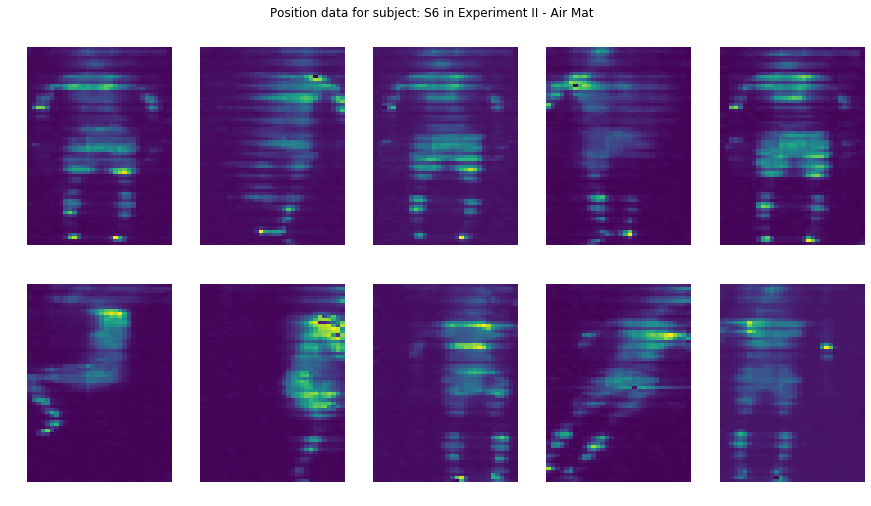

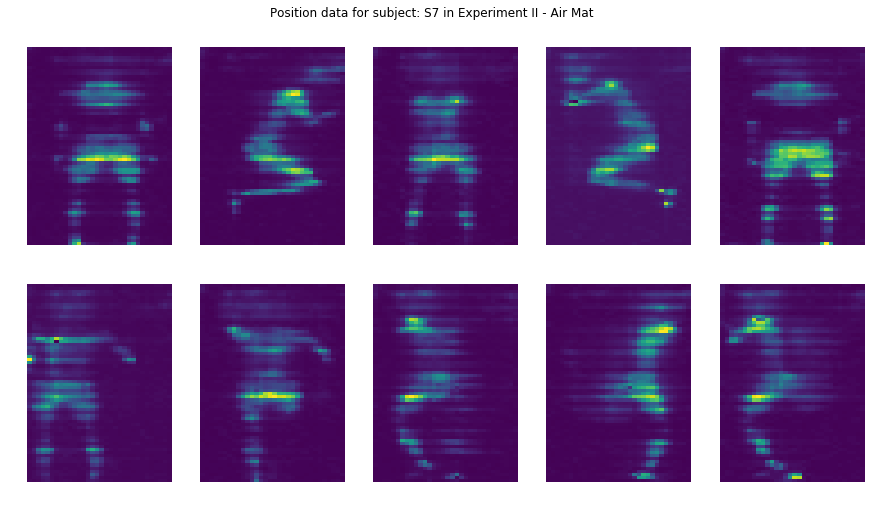

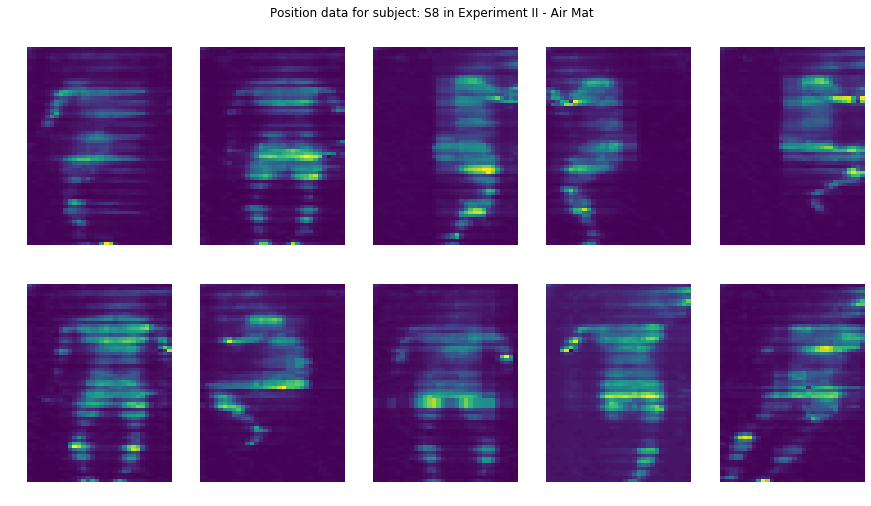

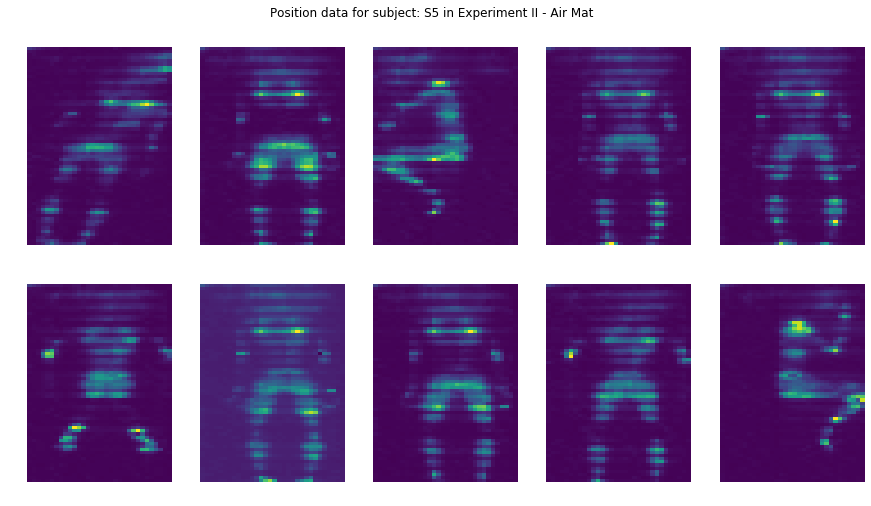

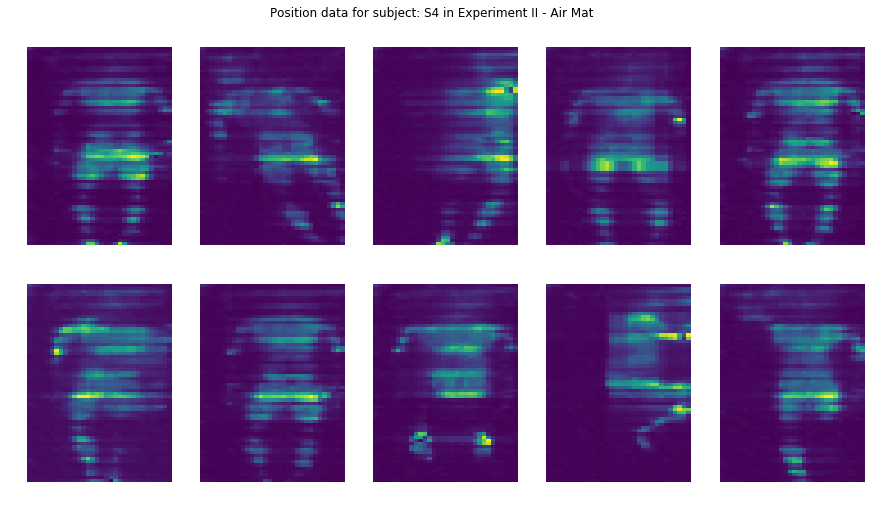

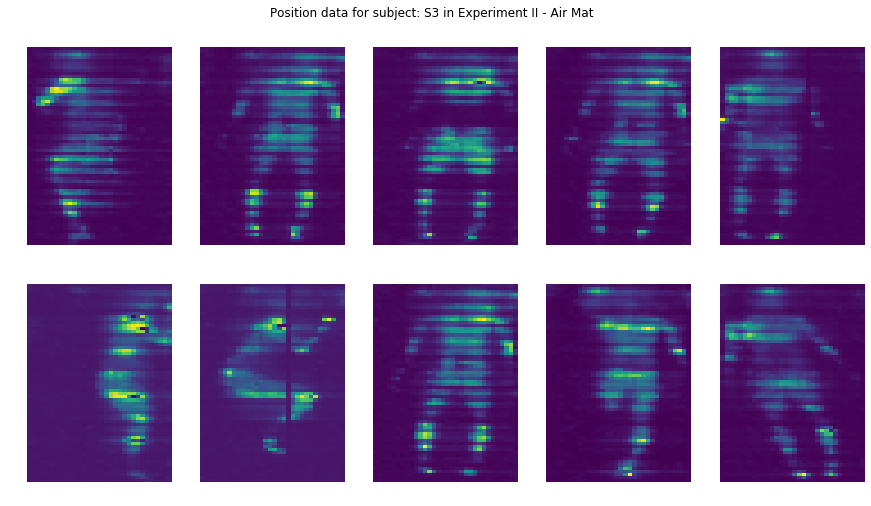

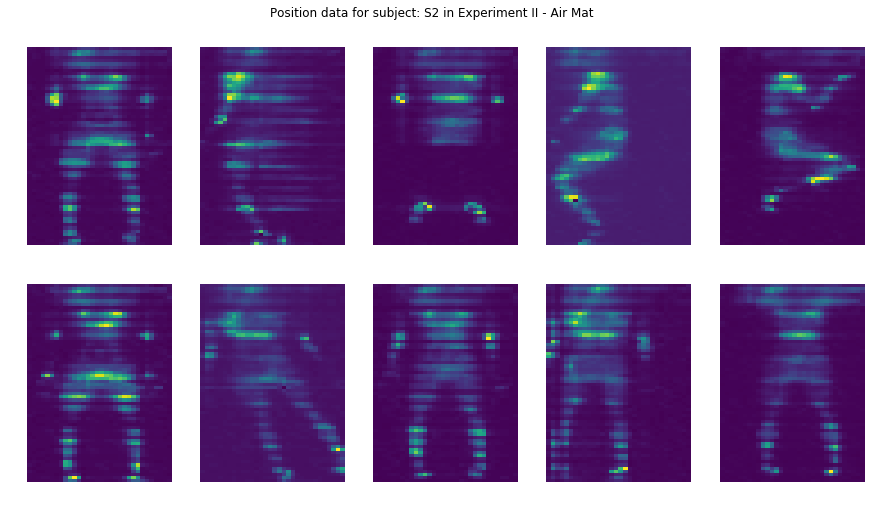

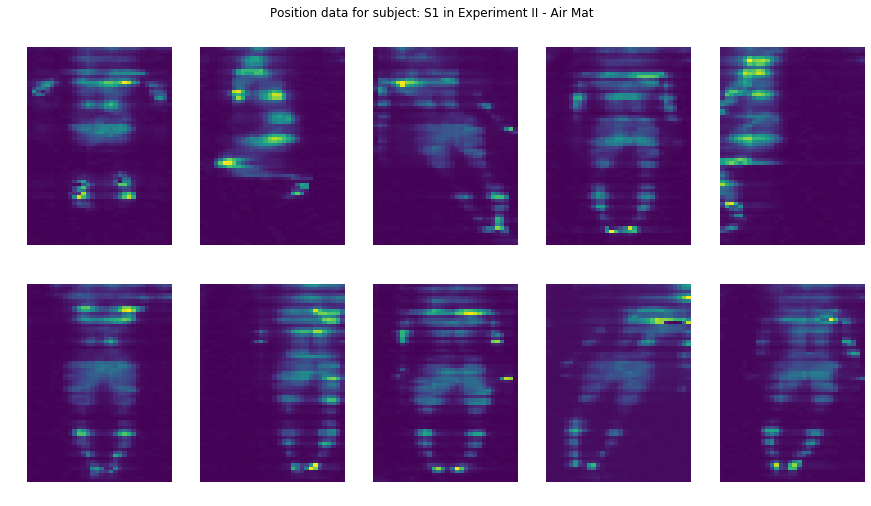

In [18]:
for subject in subjects_ii:
  
    # read the subject
  size = exp_ii_data_air[subject][0].shape[0]
  # sample
  sample = np.random.choice(range(0, size), 20, replace = False)
  # data
  data = exp_ii_data_air[subject][0].numpy()
  # plots
  f, arr = plt.subplots(2, 5, figsize = (15, 8))
  f.suptitle('Position data for subject: {} in {}'.format(subject, mats[1]), y = 0.95)
  fig = 0
  for r in range(2):
      for c in range(5):
          arr[r, c].imshow(data[sample[fig]].reshape(64, 32), aspect = 'auto')
          arr[r, c].axis('off')
          fig += 1

We see that all images have some horizontal lines where there are no measurements and also some noise on the data. This could be explained because of how this particular mattress works:

> Air-alternating mattress alternate inflation and deflation of air cells (bladders) leading to a change in pressure points. (...) Alteration constantly change pressure points and promote circulation in the individual. Therefore, alteration is set at a constant level for all subjects [(Pouyan et. al, 2017)](https://ieeexplore.ieee.org/document/7897206/).



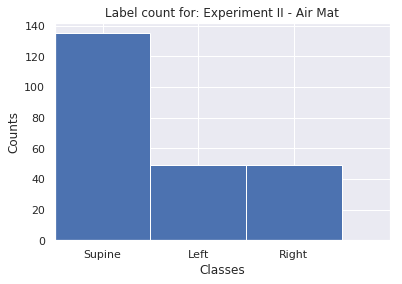

In [19]:
sns.set()
plot_hist(exp_ii_data_air, mats[1])

Here we also notice that the data is unbalanced, and that the difference between _supine_ positions and the other two is bigger.

In [0]:
# Go back to matplotlib
%%capture
sns.reset_orig()

### Sponge Mat

This is a 'traditional' mattress and the only reported difference between this mattress and the one used in 'Experiment I' are the dimensions (27" x 64", instead of 32" x 64").

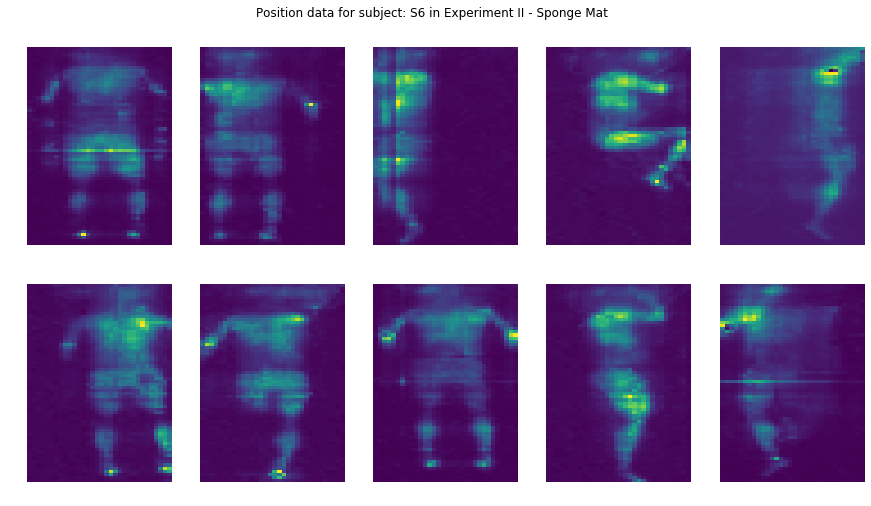

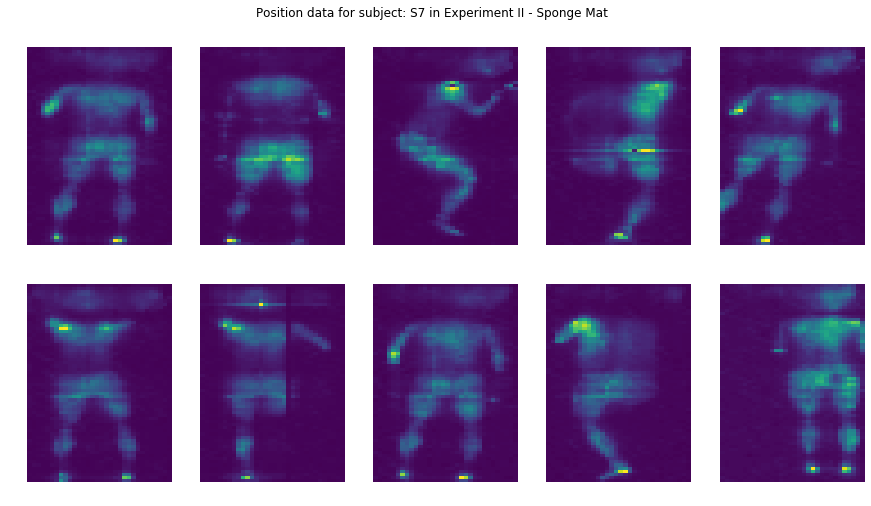

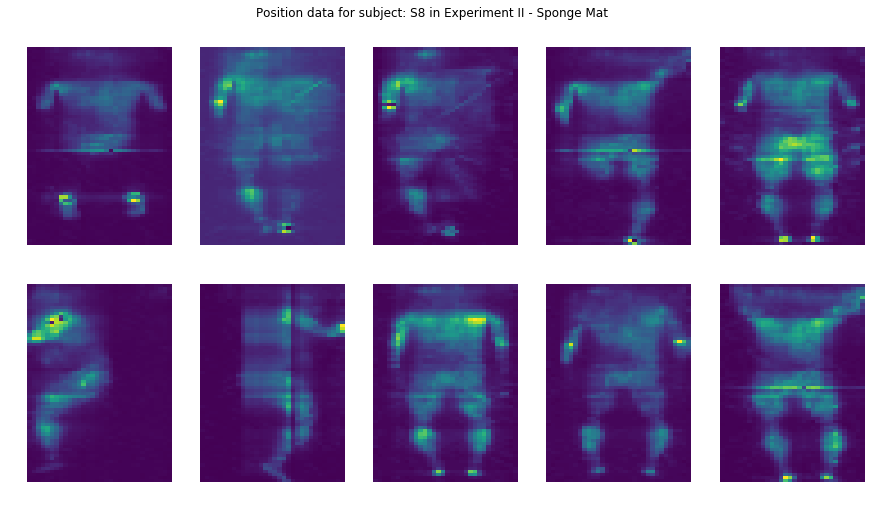

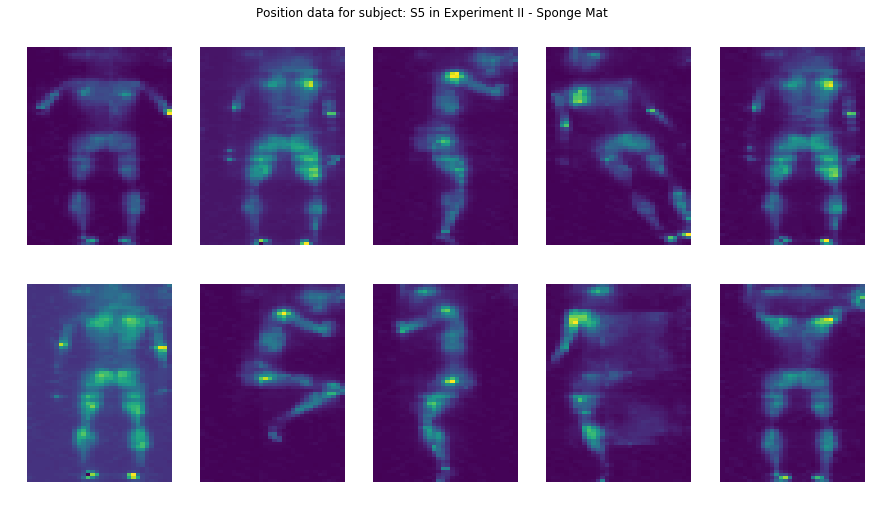

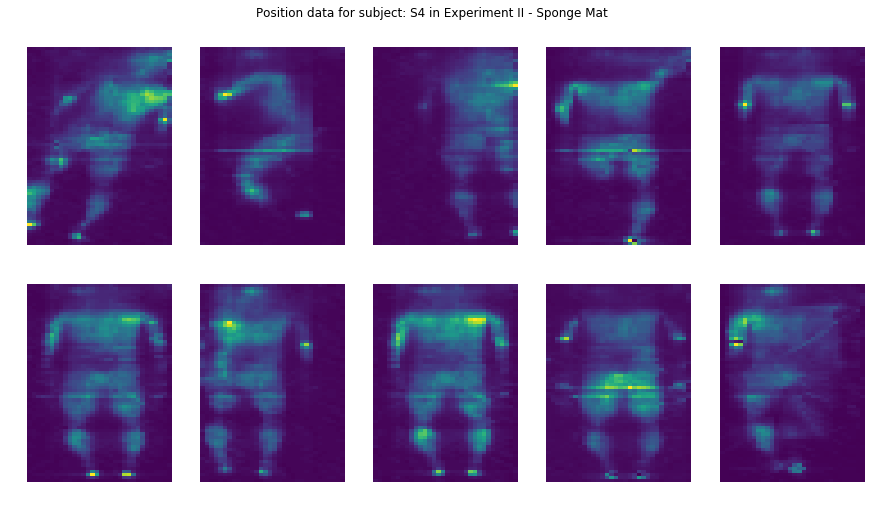

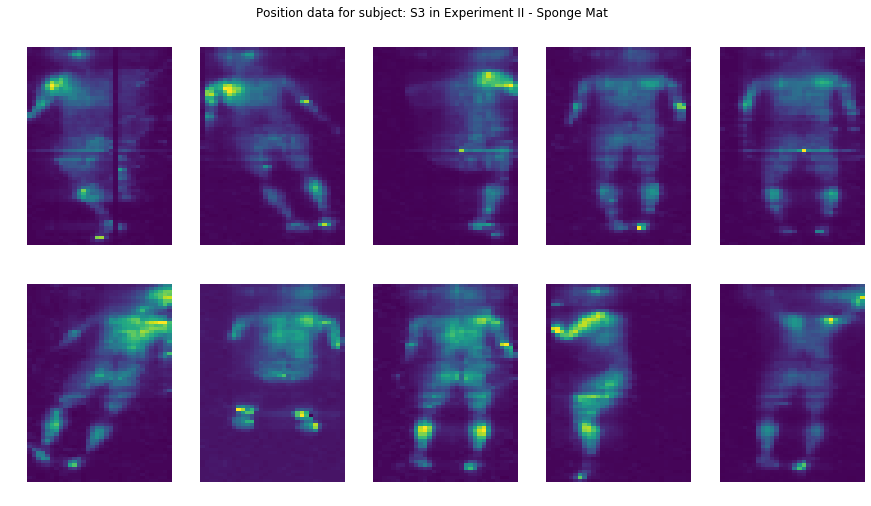

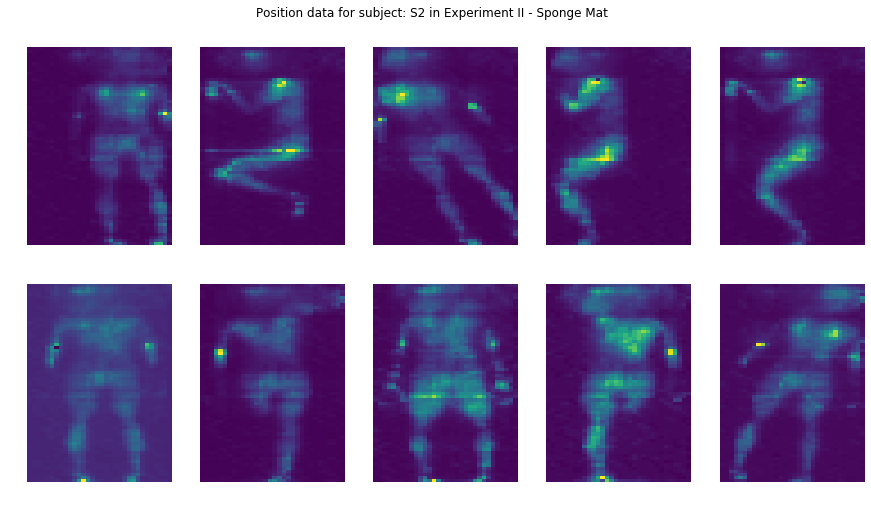

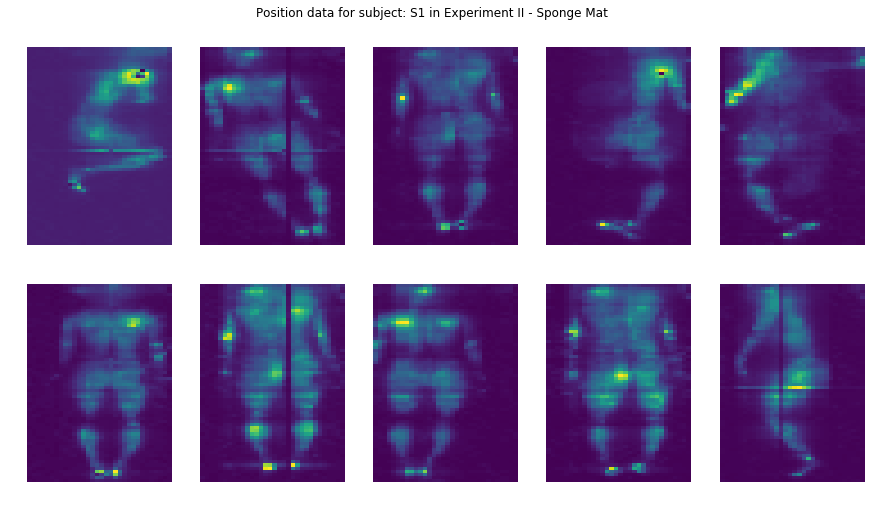

In [21]:
for subject in subjects_ii:  
  # read the subject
  size = exp_ii_data_spo[subject][0].shape[0]
  # sample
  sample = np.random.choice(range(0, size), 20, replace = False)
  # data
  data = exp_ii_data_spo[subject][0].numpy()
  # plots
  f, arr = plt.subplots(2, 5, figsize = (15, 8))
  f.suptitle('Position data for subject: {} in {}'.format(subject, mats[2]), y = 0.95)
  fig = 0
  for r in range(2):
      for c in range(5):
          arr[r, c].imshow(data[sample[fig]].reshape(64, 32), aspect = 'auto')
          arr[r, c].axis('off')
          fig += 1

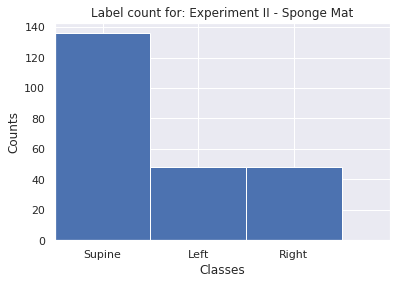

In [22]:
sns.set()
plot_hist(exp_ii_data_spo, mats[2])

In [0]:
# Go back to matplotlib
%%capture
sns.reset_orig()

As we can see, this data set have the __supine__ class as its majority one.

# Training a Shallow Model using 'Experiment I' data

After our exploration to the dataset, we want to create a shallow model to introduce the workflow on PyTorch when building a classification model using neural networks (NN). We use the only `exp_i_data` and reshape it into a flat representation to be used by the shallow model. It is _shallow_ in the sense that image classification is achieved with better results using convolutional neural networks (CNN), which will be used on Part 2.

In [0]:
data = exp_i_data[subjects_i[0]][0]
labels = exp_i_data[subjects_i[0]][1]

for subject in subjects_i[1:]:
    data = np.append(data, exp_i_data[subject][0], axis = 0)
    labels = np.append(labels, exp_i_data[subject][1], axis = 0)

data = data.reshape(-1, 2048)

We want to split the data randomly into a training and a testing set. However, we expect that the results will be overestimated, because the 'lying bed positions' scenario has low dynamics, meaning that a person remains on the same positions for several seconds and the measurements should not vary that much, meaning that most of the testing data will be similar to the training one.

In [0]:
# Set percentage of data dedicated for training
train_percent = 0.8
train_size = int(train_percent * data.shape[0])

# Generate train/test splits
dataset_size = data.shape[0]
indices = list(range(dataset_size))
split = train_size
train_indices, test_indices = indices[:split], indices[split:]

In [0]:
# Create data samplers and loaders

train_sampler = SubsetRandomSampler(train_indices)
test_sampler = SubsetRandomSampler(test_indices)
# Convert to tensor
dataset = torch.utils.data.TensorDataset(torch.from_numpy(data).float() , torch.from_numpy(labels).long())

train_loader = torch.utils.data.DataLoader(dataset, batch_size=64, shuffle = False,
                                           sampler=train_sampler)
test_loader = torch.utils.data.DataLoader(dataset, batch_size=64, shuffle = False,
                                                sampler=test_sampler)

## Model

Here we introduce the _shallow_ model: a 3-layer NN that uses ReLU and Softmax as activation functions:

In [0]:
class ShallowNet(nn.Module):
    """
    Shallow model, composed by four layers.
    """
    def __init__(self, n_inputs):
        super().__init__()
        self.fc1 = nn.Linear(n_inputs, 150)
        self.fc2 = nn.Linear(150, 150)
        self.output = nn.Linear(150, 3)
        
    def forward(self, x):      
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return F.log_softmax(self.output(x), dim = 1)

## Training

In [28]:
# Instanciate model
model = ShallowNet(2048)
model

ShallowNet(
  (fc1): Linear(in_features=2048, out_features=150, bias=True)
  (fc2): Linear(in_features=150, out_features=150, bias=True)
  (output): Linear(in_features=150, out_features=3, bias=True)
)

In [0]:
# Set model hyperparameters
model_optimizer = optim.SGD(model.parameters(), lr=0.01)
criterion = nn.NLLLoss()

In [30]:
loaders = [train_loader, test_loader]
n_epochs = 50

model.train()
running_loss = 0
train_losses, test_losses = [], []
for epoch in range(n_epochs):
    for data, labels in loaders[0]:
        model_optimizer.zero_grad()
        # Get predictions
        y_hat = model(data)
        # Calculate loss
        loss = criterion(y_hat, labels)
        loss.backward()
        # Optimize
        model_optimizer.step()
        # Show loss
        running_loss += loss.data.numpy()
    else:
        test_loss = 0
        accuracy = 0
        model.eval()

        with torch.no_grad():
            for inputs, labels in loaders[1]:
                logps = model(inputs)
                loss = criterion(logps, labels)
                test_loss += loss.data.numpy()

                ps = torch.exp(logps)
                top_p, top_class = ps.topk(1, dim=1)
                equals = top_class == labels.view(*top_class.shape)
                accuracy += torch.mean(equals.float())

        train_losses.append(running_loss/len(loaders[0]))
        test_losses.append(test_loss/len(loaders[1]))
    if (epoch + 1) % 5 == 0:
      print(f'Epoch: {epoch + 1}/{n_epochs} | Training loss: {running_loss/len(loaders[0])} | Test loss: {test_loss/len(loaders[1])} | Test accuracy: {accuracy/len(loaders[1])}')
    running_loss = 0
    model.train()

Epoch: 5/50 | Training loss: 0.2390590255965992 | Test loss: 0.31700826219974026 | Test accuracy: 0.9236391186714172
Epoch: 10/50 | Training loss: 0.025496697212968555 | Test loss: 0.17890489461921877 | Test accuracy: 0.9095456004142761
Epoch: 15/50 | Training loss: 0.012810716698212283 | Test loss: 0.1694219840029555 | Test accuracy: 0.9085375070571899
Epoch: 20/50 | Training loss: 0.008914914523840559 | Test loss: 0.16657226682910997 | Test accuracy: 0.9057653546333313
Epoch: 25/50 | Training loss: 0.006633847033871072 | Test loss: 0.1676988923141072 | Test accuracy: 0.903264582157135
Epoch: 30/50 | Training loss: 0.005414201521637792 | Test loss: 0.16237728298461485 | Test accuracy: 0.9049898982048035
Epoch: 35/50 | Training loss: 0.004653007796091237 | Test loss: 0.16309041385689088 | Test accuracy: 0.9050287008285522
Epoch: 40/50 | Training loss: 0.004083265750003713 | Test loss: 0.16179912873814184 | Test accuracy: 0.9070254564285278
Epoch: 45/50 | Training loss: 0.00362176331929

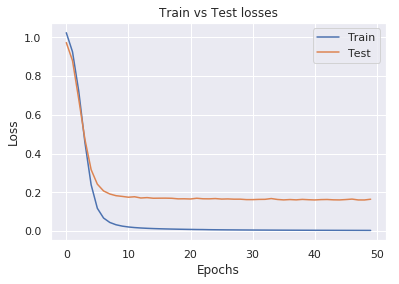

In [31]:
sns.set()
plt.plot(range(n_epochs), train_losses)
plt.plot(range(n_epochs), test_losses)
plt.title('Train vs Test losses')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Train', 'Test'])
plt.show()

We got a high accuracy and, even though it is overestimated because of the reasons mentioned before, we see that there is potential con classifying these images. 

We surely can do better using CNNs and we will show it on Part 2, where we will expand this modeling introduction and will do some other analyses.